# Scratch Notebook

In [2]:
%load_ext autoreload

import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib

import numpy as onp
from jax.config import config
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning
from kernel_learning import Optimizer

from jax.experimental import optimizers

key = random.PRNGKey(0)

from jax.scipy.stats import norm

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
from 

In [23]:
# setup = distributions.Setup(target=distributions.Gaussian(0, 16), proposal=distributions.Gaussian(0, 1))
# setup = distributions.double_mixture
setup = distributions.banana_target
target, proposal = setup.get()
kernel = kernels.get_rbf_kernel(1)

def score_est_unnormalized(x, inducing_particles):
    """kernel-smoothed estimate of grad(log q(x))"""
    return -np.mean(vmap(grad(kernel), (0, None))(inducing_particles, x))

def phistar_unnormalized(x, inducing_particles, aux=False):
    out = stein.phistar_i(x, inducing_particles, target.logpdf, kernel, aux=aux)
    if aux:
        neg_dKL, auxdata = out
        out = (-neg_dKL, auxdata)
    else:
        out = -out
    return out

## Normalize score estimate
s = proposal.sample(10_000)
inducing_particles = proposal.sample(10_000)
l2_score     = utils.l2_norm(s, grad(proposal.logpdf))
l2_score_est = utils.l2_norm(s, lambda x: score_est_unnormalized(x, inducing_particles))

def score_est(x, inducing_particles):
    """kernel-smoothed estimate of grad(log q(x)). Normalized."""
    return score_est_unnormalized(x, inducing_particles) * l2_score/l2_score_est

## Normalize kernel
def grad_kl(x):
    """True grad(KL)"""
    return setup.grad_kl(x)

l2_grad_kl = utils.l2_norm(np.squeeze(s), grad_kl)
l2_phistar = utils.l2_norm(s, lambda x: phistar_unnormalized(x, inducing_particles))

def phistar(x, inducing_particles, aux):
    if aux:
        out = phistar_unnormalized(x, inducing_particles, aux)
        return [o * l2_grad_kl/l2_phistar for o in out]
    else:
        return phistar_unnormalized(x, inducing_particles, aux) * l2_grad_kl/l2_phistar

In [24]:
def dKL(x, inducing_particles):
    """Estimate of grad(KL(x))"""
    dKL = score_est(x, inducing_particles) - grad(target.logpdf)(x)
    return dKL


def dKL_batched(particles, inducing_particles, aux=False):
    out = vmap(dKL, (0, None))(particles, inducing_particles)
    return (out, _) if aux else out


def phistar_batched(particles, inducing_particles, aux=False):
    return vmap(phistar, (0, None, None))(particles, inducing_particles, aux)

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, **kwargs)


ValueError: x needs to have shape (2,). Instead, received x of shape ().

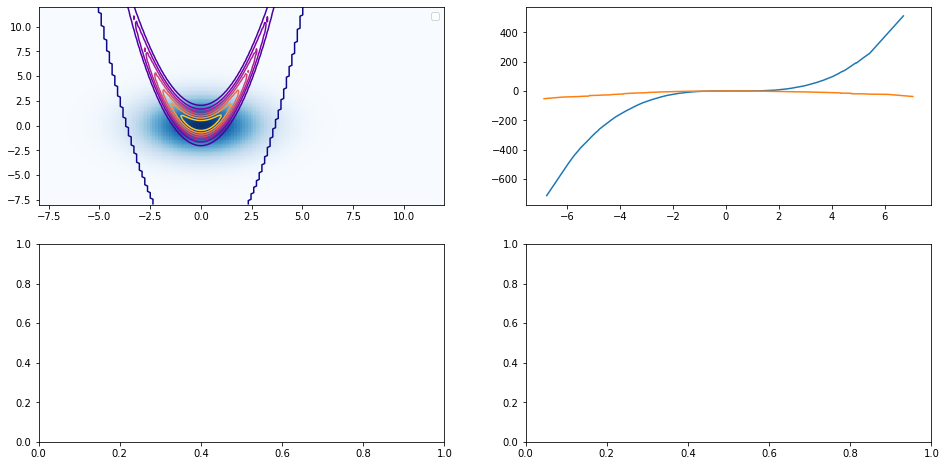

In [25]:
inducing_particles = proposal.sample(1000)
x = proposal.sample(1000)

xgrid = x.sort(axis=0)

fig, axs = plt.subplots(2,2, figsize=[16, 8])
axsiter = iter(axs.flatten())
xlims = (-8, 12)

ax = next(axsiter)
setup.plot(ax=ax, lims=xlims)
ax.legend()

ax = next(axsiter)
ax.plot(xgrid, dKL_batched(xgrid, inducing_particles), label="kernelized score matching grad(KL)")
plot.plot_fun(grad_kl, lims=xlims, ax=ax, label="True grad(KL)")
ax.legend()

ax = next(axsiter)
ax.plot(xgrid, phistar_batched(xgrid, inducing_particles), label="SVGD")
plot.plot_fun(grad_kl, lims=xlims, ax=ax, label="True grad(KL)")
ax.legend()

ax = next(axsiter)

for ax in axs.flatten():
    ax.set_xlim(xlims)

In [33]:
particles_svgd = Particles(key,
                           phistar_batched,
                           proposal,
                           learning_rate=0.01)

particles_score = Particles(key,
                            dKL_batched,
                            proposal,
                            learning_rate=0.01)

In [34]:
for _ in range(2500):
    inducing_particles = particles_svgd.get_params()
    particles_svgd.step(params=inducing_particles)

# _ = plt.hist(particles_svgd.get_params()[:,0], bins=25, density=True, alpha=0.5)
# _ = plot.plot_fun(target.pdf, lims=(-10, 10))

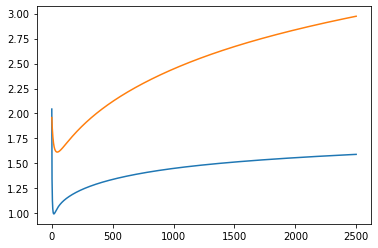

In [39]:
plt.plot(particles_svgd.rundata["std"], label="SVGD")

In [ ]:
sdfkj

# markdown image link converter

Format 1:
```
![img](/home/lauro/obsidian/Pasted image 14.png)
```
Format 2:
```
![[Pasted image 5.png]]
```

In [ ]:
string_f1 = "kxkjdf![img](/home/lauro/obsidian/Pasted image 14.png)xdkfjdlk\n"
string_f2 = "![[Pasted image 14.png]]sdlfsdfsdfj\n"

In [ ]:
def f1_to_f2(string):
    ind_begin = string.rindex("/") # last occurence of /
    ind_end = string.rindex(")") # last occurence of )
    name = string[ind_begin+1:ind_end]
    return f"![[{name}]]"

def f2_to_f1(string):
    ind_begin = string.index("!")
    ind_end = string.rindex("]")
    name = string[ind_begin+3:ind_end-1]
    return f"![img](/home/lauro/obsidian/{name})"

def line_is_f1_img(line):
    return line.startswith("![img]") and line.endswith(".png)\n")

def line_is_f2_img(line):
    return line.startswith("![[") and line.endswith(".png]]\n")

In [ ]:
def convert_file(filename, direction="f1_to_f2"):
    if direction == "f1_to_f2":
        convert = f1_to_f2
        is_img = line_is_f1_img
    elif direction == "f2_to_f1":
        convert = f2_to_f1
        is_img = line_is_f2_img
    else:
        raise ValueError()
    with open(filename, "r") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if is_img(line):
                line_converted = convert(line)
                lines[i] = line_converted + "\n"
                print(f"changed line: {line}")
    with open(filename, "w") as f:
        f.writelines(lines)

In [ ]:
# filename = "/home/lauro/testfile"
# convert_file(filename, direction="f1_to_f2")

In [ ]:
# filename = "/home/lauro/obsidian/Master thesis/Updates/Update September 8.md"

In [ ]:
convert_file(filename, direction="f1_to_f2")